In [43]:
import torch
from keras import Sequential, Input
from keras.src.layers import Dense, Dropout
from keras.src.utils import to_categorical
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from transformers import BertTokenizer, BertModel
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

## Task 5 - Using Pretrained Vectors

First load the ground truth dataset which contains the reviews and their corresponding sentiment labels.

In [7]:
reviews = pd.read_csv('ground_truth_reviews.csv')
ground_truth = reviews['ground_truth_sentiment'].values

### 5.1. Using BERT for Text Embeddings

Here, we choose to go with BERT (Bidirectional Encoder Representations from Transformers) for generating text embeddings. BERT is a powerful transformer-based model that captures the context of words in a sentence.

In [2]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

C:\Users\kanee\.virtualenvs\sri-lanka-hotel-reviews\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\kanee\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to reg

We can use BERT to generate embeddings for each review. The embeddings will be the output of the [CLS] token, which is designed to capture the overall meaning of the text.

In [8]:
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    return cls_embedding

Then we can apply this function to the reviews in our dataset to generate the embeddings.

In [9]:
reviews = pd.read_csv('ground_truth_reviews.csv')
bert_vectors = reviews['review'].apply(get_bert_embedding)
bert_vectors = np.vstack(bert_vectors.values)

In [11]:
print(bert_vectors.shape)

(5186, 768)


Here, we can see that the shape of `bert_vectors` is `(5186, 768)`, where 768 is the dimensionality of the BERT embeddings.

### 5.2. Classifying with BERT Embeddings

Here, similar to task 4, we will use the BERT embeddings to train various classifiers and evaluate their performance. We will use Naive Bayes, SVM, and Random Forest.

In [12]:
def classifier(features, ground_truth, name, clf):
    y_pred = cross_val_predict(clf, features, ground_truth, cv=5)
    print(f'Accuracy for {name}: {accuracy_score(ground_truth, y_pred):.4f}')
    print(f"Precision for {name}: {precision_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"Recall for {name}: {recall_score(ground_truth, y_pred, average='weighted'):.4f}")
    print(f"F1 Score for {name}: {f1_score(ground_truth, y_pred, average='weighted'):.4f}")

    cm = confusion_matrix(ground_truth, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(text_kw={'color': 'black'})
    plt.title(f'Confusion Matrix for Naive Bayes on {name} Features')
    plt.show()

    return f1_score(ground_truth, y_pred, average='weighted')

Accuracy for Bag of Words: 0.9335
Precision for Bag of Words: 0.9414
Recall for Bag of Words: 0.9335
F1 Score for Bag of Words: 0.9366


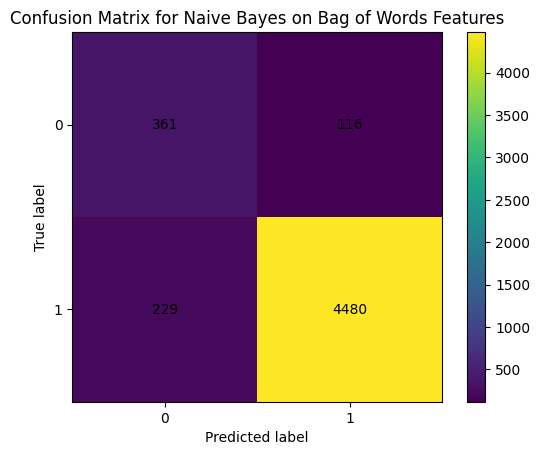

0.9365934570685694

In [19]:
classifier(MinMaxScaler().fit_transform(bert_vectors), ground_truth, "Bag of Words", MultinomialNB())

Accuracy for SVM: 0.9578
Precision for SVM: 0.9554
Recall for SVM: 0.9578
F1 Score for SVM: 0.9550


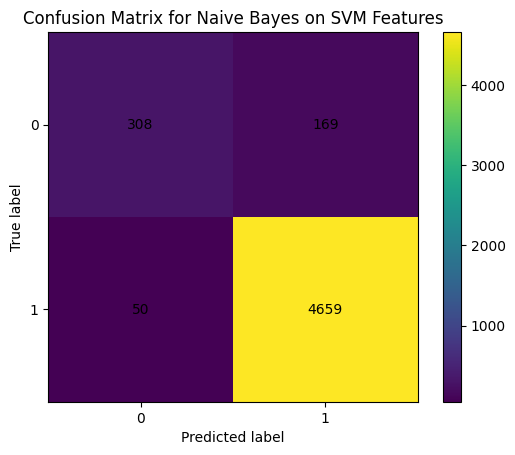

0.9550252450711283

In [25]:
classifier(bert_vectors, ground_truth, "SVM", SVC(kernel='rbf'))

Accuracy for Random Forest: 0.9389
Precision for Random Forest: 0.9351
Recall for Random Forest: 0.9389
F1 Score for Random Forest: 0.9283


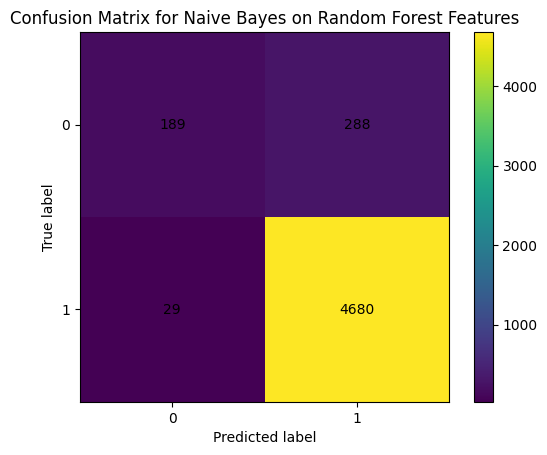

0.9283022108920118

In [29]:
classifier(bert_vectors, ground_truth, "Random Forest", RandomForestClassifier())

We see that the SVM classifier performs the best with an F1 score of 0.955. But we were able to achieve a better performance using Word2Vec and SVM.

### 5.3. Using BERT Embeddings in a Neural Network

Here, we build and train a simple neural network using the BERT embeddings. The architecture consists of two hidden layers with ReLU activation and dropout for regularization. The hyperparameters were tuned to achieve the best performance after several trials.

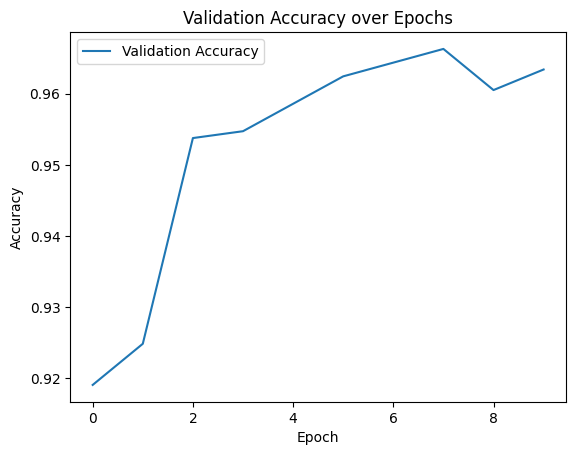

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Fold: Accuracy=0.9634, Precision=0.9667, Recall=0.9634, F1=0.9646


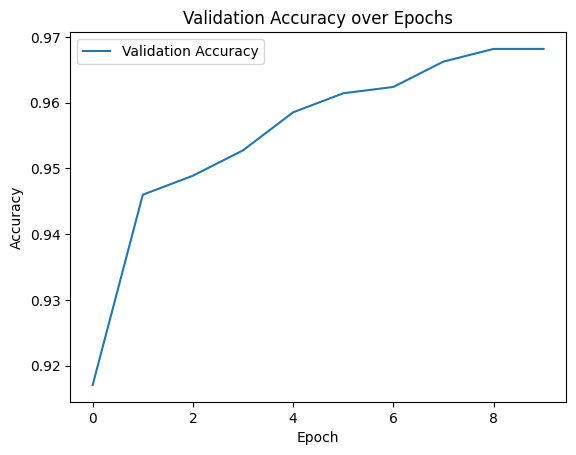

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold: Accuracy=0.9682, Precision=0.9668, Recall=0.9682, F1=0.9670


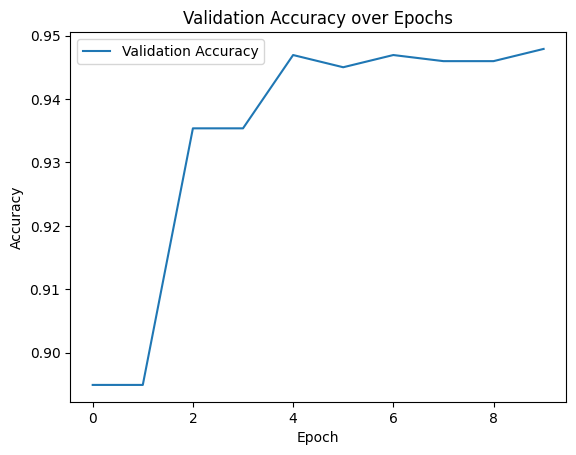

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Fold: Accuracy=0.9479, Precision=0.9449, Recall=0.9479, F1=0.9453


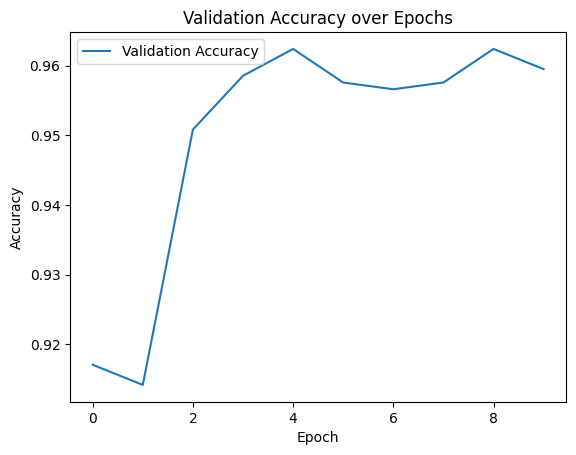

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold: Accuracy=0.9595, Precision=0.9604, Recall=0.9595, F1=0.9599


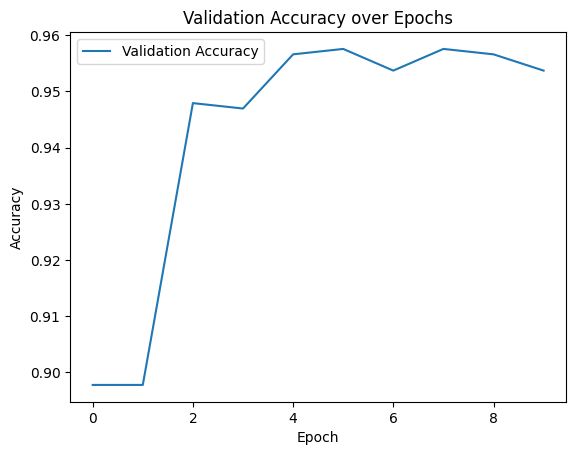

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Fold: Accuracy=0.9537, Precision=0.9514, Recall=0.9537, F1=0.9518
Mean Accuracy: 0.9585
Mean Precision: 0.9580
Mean Recall: 0.9585
Mean F1 Score: 0.9577


In [54]:
X = bert_vectors
le = LabelEncoder()
y = le.fit_transform(ground_truth)
y_cat = to_categorical(y, num_classes=len(np.unique(y)))
kf = KFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, prec_scores, rec_scores, f1_scores = [], [], [], []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(512, activation='relu'),
        Dropout(0.6),
        Dense(2, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=512,
        validation_data=(X_val, y_val),
        verbose=0
    )

    # Plot validation accuracy
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.show()    
    
    y_val_pred = model.predict(X_val)
    y_val_pred_labels = np.argmax(y_val_pred, axis=1)
    y_val_true_labels = np.argmax(y_val, axis=1)

    acc = accuracy_score(y_val_true_labels, y_val_pred_labels)
    prec = precision_score(y_val_true_labels, y_val_pred_labels, average='weighted', zero_division=0)
    rec = recall_score(y_val_true_labels, y_val_pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(y_val_true_labels, y_val_pred_labels, average='weighted', zero_division=0)

    acc_scores.append(acc)
    prec_scores.append(prec)
    rec_scores.append(rec)
    f1_scores.append(f1)

    print(f'Fold: Accuracy={acc:.4f}, Precision={prec:.4f}, Recall={rec:.4f}, F1={f1:.4f}')

print(f'Mean Accuracy: {np.mean(acc_scores):.4f}')
print(f'Mean Precision: {np.mean(prec_scores):.4f}')
print(f'Mean Recall: {np.mean(rec_scores):.4f}')
print(f'Mean F1 Score: {np.mean(f1_scores):.4f}')

Here, we see that the neural network achieves a mean F1 score of 0.958, which is comparable to the SVM classifier.

The plots of the validation accuracy over epochs show that the model is learning and improving its performance over time, but there is diminishing returns after around 5 epochs.